In [4]:
import os, sys
from pathlib import Path

nb_dir = Path.cwd()
repo_root = nb_dir.parent
sys.path.insert(0, str(repo_root))

print("Notebook dir:", nb_dir)
print("Repo root:", repo_root)

Notebook dir: h:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\notebooks
Repo root: h:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion


In [5]:
import os
import numpy as np
import torch

from src.geo_constraints import DataPaths
from src.dataset_vie import StanfordVIEWellPatchDataset
from src.models.geo_cnn_multitask import GeoCNNMultiTask

DATA_ROOT = r"H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data"
paths = DataPaths(DATA_ROOT)

constraints_npz = os.path.join(paths.processed_dir, "constraints.npz")
ds = StanfordVIEWellPatchDataset(paths, constraints_npz, patch_hw=4, use_masked_y=True, normalize=True)

split_dir = os.path.join(paths.processed_dir, "splits")
val_idx = np.load(os.path.join(split_dir, "val_idx.npy"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = os.path.join(paths.processed_dir, "checkpoints_multitask_facies_warmup_fix", "best_joint.pt")
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
print("epoch", ckpt["epoch"], "mode", ckpt.get("mode"), "best", ckpt["best_val"])


model = GeoCNNMultiTask(in_channels=7, base=32, t=200, n_facies=4).to(device)
model.load_state_dict(ckpt["model_state"])
model.eval()

# --- AI metrics on val (masked interval) ---
y_all = []
yhat_all = []

with torch.no_grad():
    for idx in val_idx.tolist():
        b = ds[idx]
        x = b["x"][None].to(device)
        p = b["p"][None].to(device)
        c = b["c"][None].to(device)
        m = b["m"][None].to(device)
        y = b["y"].cpu().numpy()  # [T]

        H = b["m"].shape[1]; W = b["m"].shape[2]
        mc = b["m"][0, H//2, W//2, :].numpy().astype(np.float32)  # [T]

        ai_hat, fac_logits = model(x, p, c, m)
        y_hat = ai_hat[0].cpu().numpy()

        # keep only masked samples
        keep = mc > 0.5
        y_all.append(y[keep])
        yhat_all.append(y_hat[keep])

y_all = np.concatenate(y_all)
yhat_all = np.concatenate(yhat_all)

mae = np.mean(np.abs(yhat_all - y_all))
rmse = np.sqrt(np.mean((yhat_all - y_all)**2))
corr = np.corrcoef(yhat_all, y_all)[0,1]

print("Val masked MAE:", mae)
print("Val masked RMSE:", rmse)
print("Val masked Corr:", corr)

epoch 37 mode best_joint best 0.6672976732254028
Val masked MAE: 0.49094036
Val masked RMSE: 0.6631068
Val masked Corr: 0.7577667332026429


In [6]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

y_true = []
y_pred = []

with torch.no_grad():
    for idx in val_idx.tolist():
        b = ds[idx]
        x = b["x"][None].to(device)
        p = b["p"][None].to(device)
        c = b["c"][None].to(device)
        m = b["m"][None].to(device)

        fac = b["facies_center"].numpy()           # [T] in {0..3} or -1
        valid = b["facies_valid"].numpy() > 0.5    # [T]

        ai_hat, fac_logits = model(x, p, c, m)
        pred = fac_logits[0].argmax(dim=0).cpu().numpy()  # [T]

        keep = valid & (fac >= 0)
        if keep.sum() == 0:
            continue

        y_true.append(fac[keep])
        y_pred.append(pred[keep])

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

acc = accuracy_score(y_true, y_pred)
mf1 = f1_score(y_true, y_pred, average="macro")
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])

print("Facies val accuracy:", acc)
print("Facies val macro-F1 :", mf1)
print("Confusion matrix (0..3):\n", cm)

from sklearn.metrics import classification_report, f1_score

print("Weighted-F1:", f1_score(y_true, y_pred, average="weighted"))
print(classification_report(y_true, y_pred, labels=[0,1,2,3], digits=4))

Facies val accuracy: 0.7789782244556114
Facies val macro-F1 : 0.5121157710958911
Confusion matrix (0..3):
 [[6559   11  696   27]
 [  49  149  793   15]
 [ 532  109 2524   21]
 [ 240   19  127   69]]
Weighted-F1: 0.7582977321895472
              precision    recall  f1-score   support

           0     0.8888    0.8994    0.8940      7293
           1     0.5174    0.1481    0.2303      1006
           2     0.6097    0.7922    0.6891      3186
           3     0.5227    0.1516    0.2351       455

    accuracy                         0.7790     11940
   macro avg     0.6346    0.4978    0.5121     11940
weighted avg     0.7690    0.7790    0.7583     11940



C:\Users\Windows\AppData\Local\Temp\ipykernel_38412\1096309096.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].twinx().legend(loc="upper right")


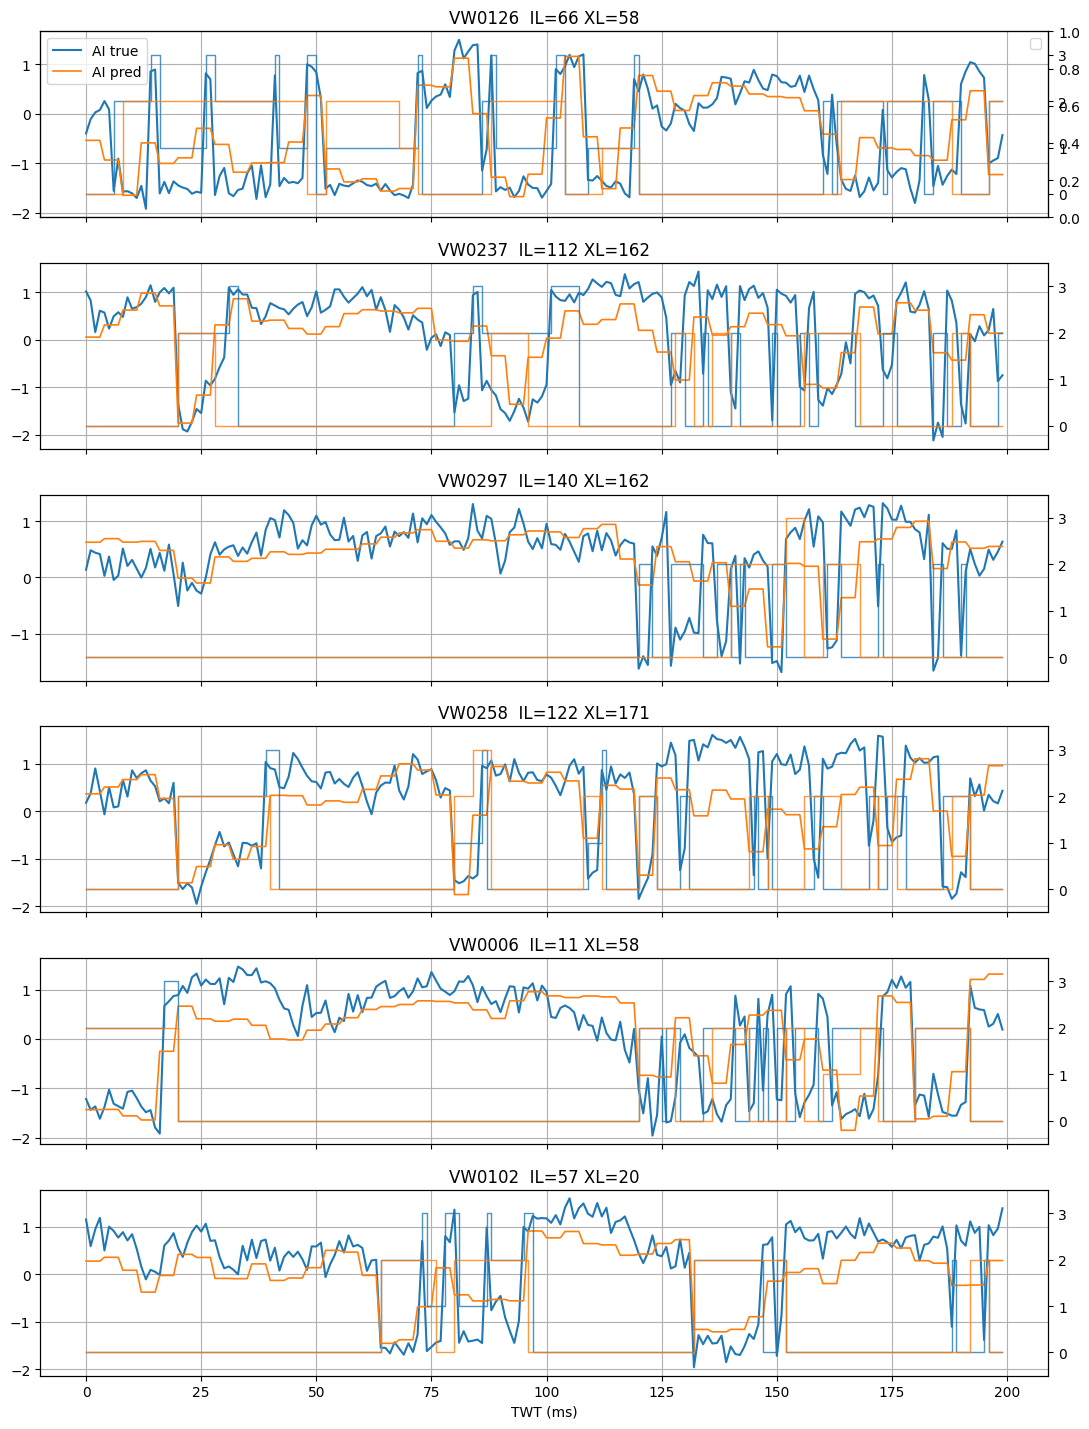

In [7]:
import random, numpy as np, matplotlib.pyplot as plt
import torch

random.seed(2026)
show_ids = random.sample(val_idx.tolist(), 6)
t = np.arange(200)

fig, axes = plt.subplots(len(show_ids), 1, figsize=(11, 2.4*len(show_ids)), sharex=True)

with torch.no_grad():
    for ax, idx in zip(axes, show_ids):
        b = ds[idx]
        x = b["x"][None].to(device)
        p = b["p"][None].to(device)
        c = b["c"][None].to(device)
        m = b["m"][None].to(device)

        y = b["y"].cpu().numpy()
        fac = b["facies_center"].cpu().numpy()
        valid = b["facies_valid"].cpu().numpy() > 0.5

        H = b["m"].shape[1]; W = b["m"].shape[2]
        mc = b["m"][0, H//2, W//2, :].cpu().numpy()

        ai_hat, fac_logits = model(x, p, c, m)
        y_hat = ai_hat[0].cpu().numpy()
        pred = fac_logits[0].argmax(dim=0).cpu().numpy()

        # mask interval only
        keep = mc > 0.5

        ax.plot(t[keep], y[keep], label="AI true", linewidth=1.5)
        ax.plot(t[keep], y_hat[keep], label="AI pred", linewidth=1.2)

        # facies overlay (only valid)
        # show as thin step line; invalid points -> NaN
        fac_true = np.where(valid & keep & (fac>=0), fac, np.nan)
        fac_pred = np.where(valid & keep & (fac>=0), pred, np.nan)

        ax2 = ax.twinx()
        ax2.step(t, fac_true, where="post", linewidth=1.0, alpha=0.8, label="facies true")
        ax2.step(t, fac_pred, where="post", linewidth=1.0, alpha=0.8, label="facies pred")
        ax2.set_ylim(-0.5, 3.5)
        ax2.set_yticks([0,1,2,3])

        ax.set_title(f"{b['wellname']}  IL={int(b['il'])} XL={int(b['xl'])}")
        ax.grid(True)

axes[0].legend(loc="upper left")
axes[0].twinx().legend(loc="upper right")
axes[-1].set_xlabel("TWT (ms)")
plt.tight_layout()
plt.show()
